<a href="https://colab.research.google.com/github/vinayakareddy/Political-Sentimental-Analysis/blob/master/Sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/Political dataset/"

In [0]:
import pandas as pd

import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# **Preprocessing**
For each comments without political party names , We are adding political party names beside political leader names . For example in BJP file "modi is the best" is replaced by "BJP modi is the best" or "Rahul Gandhi is the best" is replaced by "Congress Rahul Gandhi is the best". Here BJP and Congress are the prominent Indian political parties. We are putting it in each documents(comments) so that model can learn easily to classify them into favour of BJP or Congress.

In [0]:
df_bjp = pd.read_csv(path+"BJP_dataset.csv", encoding="ISO-8859-1")


def returneditedBJP (x): 
  comment = x.lower()
  if( (' rahul ' not in comment and 'rahul ' not in comment) and ' congress ' not in comment and ' cong ' not in comment):
    comment = ' BJP ' + comment
  elif ('rahul' in comment or ' rahul' in comment or 'rahul ' in comment):
    comment = comment.replace('rahul', ' CONGRESS RAHUL ' )

  return comment

  


df_bjp['commentText'] =  df_bjp['commentText'].apply(lambda x : returneditedBJP(x)) 

    
#df_bjp['commentText'] =  df_bjp['commentText'].apply(lambda x : ' BJP ' + x if 'Rahul'  not in x.split()) 


def returnedited (x):
  comment = x.lower()
  if( (' modi ' not in comment or 'modi ' not in comment) and ' bjp ' not in comment):
    comment = ' CONGRESS ' + comment
    
  elif ( 'modi '  in comment or  ' modi' in comment) :
    comment = comment.replace('modi ', ' BJP MODI ' )
    
  return comment

df_congress = pd.read_csv(path+"Congress_dataset.csv", encoding="ISO-8859-1")
df_congress['commentText'] =  df_congress['commentText'].apply(lambda x : returnedited(x)) 

    
    
  
#creating new column newlabel   
df_congress["newLabel"] = 0

df_congress.columns
df_bjp.head()  
#df_bjp= df_congress
#df_bjp.head()

,commentText,Label
0,BJP banda apna 100 % best he,1
1,BJP we need the king maker ---- narendra modi,1
2,BJP awesome... banda apna best hai,1
3,BJP best pm ever,1
4,CONGRESS RAHUL gandhi left the chat,1


In [0]:
#Assigning 1 where comments are in favour of BJP and 0 where in favour of congress in comments of congress related xls file.
df_congress.newLabel[df_congress.Label == 0] =1
df_congress.newLabel[df_congress.Label == 1] =0
#dropping column label
df_congress.drop(columns="Label", inplace= True)
#renaming column newlabel to label
df_congress.rename(columns={"newLabel":"Label"} , inplace= True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
print(df_bjp.shape)
print(df_congress.shape)
#merging dataframes of bjp and congress
df_bjp = pd.concat([df_bjp, df_congress])

print(df_bjp.shape)
df_bjp.columns
df_bjp.reset_index(inplace= True)

(1952, 2)
(1998, 2)
(3950, 2)


In [0]:
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
punc = ['.', ',', '"', "'", '?','??', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%",'???']
# hingstops= ['kaun', 'kyun', 'im', 'm', 'i', 'se', 'u', 'esi', 'ho', 'is', 'aap', 'ab', 'actually', 'alreadi', 'always', 'amaz', 'ap', 'apna', 'apne', 'apni', 'aur', 'b', 'j', 'b', 'j', 'p', 
#             'banda', 'aa', 'aab', 'aadmi', 'aam', 'ad' ,'agar' ,'aisa', 'aise', 'aisi', 'ak', 'bar', 'aur', 'away', 'b', 'baad', 'd', 'abhi', 'baat', 'hai'
#             'h', 'ko', 'ku', 'vs', 'boy', 'bro', 'brothers', 'sisters' ,'sister', 'brother', 'bt', 'c', 'chal', 'chale', 'cm', 'com', 'yaar',
#             'bhar', 'bhi', 'itni', 'bhot', 'bhut', 'bilkul', 'till', 'tha' ,'h', 'ye' ,'y', 'yuhi', 'yun', 'to', 'e', 'ki', 'ad', 'd', 'g', 'tha', 'modi','rahul','2019']
stop_words= punc

len(stop_words)
#stop_words

17

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = SnowballStemmer('english')

wordnet_lemmatizer = WordNetLemmatizer()
    
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

   
  
def tokenize(text):
  wordlist= []
  for word in tokenizer.tokenize(text.lower()):
    wordlist.append(word) 
    #wordlisy.append(stemmer.stem(word))
  return wordlist

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Keras tokenizer and Train Test Split¶

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
from sklearn.model_selection import train_test_split


max_fatures = 5800 #or vocab size
#Keras tokenizer 
tokenizer = Tokenizer(nb_words=max_fatures, split=' ', )
tokenizer.fit_on_texts(df_bjp.commentText.values)
X1 = tokenizer.texts_to_sequences(df_bjp.commentText.values)
X1 = sequence.pad_sequences(X1, maxlen= max_fatures)

Y1 = (df_bjp.Label).values #pd.get_dummies

#Train test split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(X1_train[0:10])

(2962, 5800) (2962,)
(988, 5800) (988,)
Found 5824 unique tokens.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


# **MODELS**
# CNN_LSTM

In [0]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from numpy.random import seed
embed_dim = 150
lstm_out = 500
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1], dropout=0.1))
model.add(Conv1D(64, kernel_size=5, activation='relu')) #64 * 64 # 128 * 128 5 FILTERS i/p - 10 filters +1 = 491
model.add(MaxPooling1D(pool_size=4)) # 4 LAYERS OF POOLING
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64,  return_sequences = False))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5800, 150)         870000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5796, 64)          48064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1449, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1448, 64)          8256      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 362, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

# Training the model

In [0]:
import time

start_time = time.clock()

model.fit(X1_train,Y1_train,batch_size=150,epochs=15,verbose=1)
print (time.clock() - start_time, "seconds")

Epoch 1/15
2962/2962 [==============================] - 14s 5ms/step - loss: 0.6924 - acc: 0.5378
Epoch 2/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.6707 - acc: 0.6610
Epoch 3/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.5333 - acc: 0.7397
Epoch 4/15
2962/2962 [==============================] - 12s 4ms/step - loss: 0.3208 - acc: 0.8785
Epoch 5/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.1944 - acc: 0.9298
Epoch 6/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.1316 - acc: 0.9564
Epoch 7/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.0936 - acc: 0.9673
Epoch 8/15
2962/2962 [==============================] - 12s 4ms/step - loss: 0.0783 - acc: 0.9733
Epoch 9/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.0555 - acc: 0.9828
Epoch 10/15
2962/2962 [==============================] - 13s 4ms/step - loss: 0.0535 - acc: 0.9851
Epoch 11/15
2962/29

# Evaluating CNN-LSTM

In [0]:
model.evaluate(X1_test, Y1_test)
#output: [loss, accuracy]

988/988 [==============================] - 6s 7ms/step


[0.9098198437980312, 0.8046558711692872]

# ROC for CNN-LSTM

AUC: 0.8544135726579788


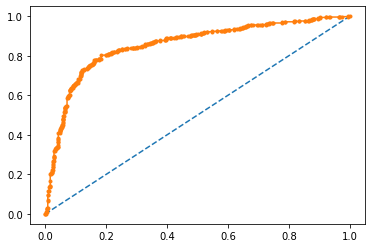

In [0]:
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(Y1_test, model.predict(X1_test))
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X1_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y1_test, model.predict(X1_test))

from sklearn.metrics import roc_auc_score, auc
from matplotlib import pyplot
print("AUC: "+ str(auc(fpr_keras, tpr_keras)))
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr_keras, tpr_keras, marker='.')
# show the plot
pyplot.show()

# **Confusion Matrix CNN-LSTM**

In [0]:
confusion_matrix(Y1_test, np.round(model.predict(X1_test)))

array([[462,  28],
       [416,  82]])

# **MultiLayer Perceptron using TF-IDF vectorization**



In [0]:
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 5300,ngram_range=(1,5), lowercase= True)

In [0]:
tfdf = vectorizer.fit_transform(df_bjp.commentText)

In [0]:
words = vectorizer.get_feature_names()

# Train test split

In [0]:
from sklearn.model_selection import train_test_split
y= df_bjp.Label
X_train, X_test, y_train, y_test = train_test_split( tfdf, y, test_size=0.2, random_state=42)

# Building MLP

In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
mlp = Sequential()
mlp.add(Dense(500, input_dim=5300, activation='relu'))
mlp.add(Dropout(0.1))
mlp.add(Dense(550, activation='relu'))
mlp.add(Dropout(0.1))

mlp.add(Dense(100, activation='relu'))
mlp.add(Dropout(0.1))

mlp.add(Dense(10, activation='relu'))
mlp.add(Dropout(0.1))


mlp.add(Dense(1, activation='sigmoid'))
#best2937 hiddden 200 1
# 82.10 500 550 500 5000 10
# Compile model
from keras import optimizers
opt =optimizers.adamax(lr=0.001)
mlp.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(mlp.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 500)               2650500   
_________________________________________________________________
dropout_29 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 550)               275550    
_________________________________________________________________
dropout_30 (Dropout)         (None, 550)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               55100     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)               

In [0]:
import time
start_time = time.clock()

# Fit the model
mlp.fit(X_train, y_train, epochs=15, batch_size=150 )

print (time.clock() - start_time, "seconds")

Epoch 1/15
3160/3160 [==============================] - 1s 300us/step - loss: 0.6732 - acc: 0.6589
Epoch 2/15
3160/3160 [==============================] - 0s 75us/step - loss: 0.5262 - acc: 0.8070
Epoch 3/15
3160/3160 [==============================] - 0s 74us/step - loss: 0.3409 - acc: 0.8722
Epoch 4/15
3160/3160 [==============================] - 0s 75us/step - loss: 0.2265 - acc: 0.9288
Epoch 5/15
3160/3160 [==============================] - 0s 71us/step - loss: 0.1670 - acc: 0.9500
Epoch 6/15
3160/3160 [==============================] - 0s 71us/step - loss: 0.1311 - acc: 0.9620
Epoch 7/15
3160/3160 [==============================] - 0s 70us/step - loss: 0.1063 - acc: 0.9671
Epoch 8/15
3160/3160 [==============================] - 0s 68us/step - loss: 0.0869 - acc: 0.9769
Epoch 9/15
3160/3160 [==============================] - 0s 78us/step - loss: 0.0778 - acc: 0.9788
Epoch 10/15
3160/3160 [==============================] - 0s 80us/step - loss: 0.0720 - acc: 0.9804
Epoch 11/15
3160/3

# **Evaluating MLP**

In [0]:
print(mlp.evaluate(X_test, y_test))
##output: [loss, accuracy]

790/790 [==============================] - 0s 305us/step
[0.6052622429177731, 0.8253164564506917]


# **ROC For MLP**

AUC: 0.9050998594071991


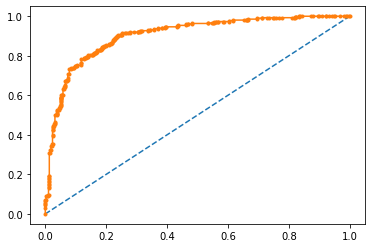

In [0]:
# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(Y1_test, model.predict(X1_test))
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, mlp.predict(X_test))

from sklearn.metrics import roc_auc_score, auc
from matplotlib import pyplot

print("AUC: "+ str(auc(fpr_keras, tpr_keras)))

pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr_keras, tpr_keras, marker='.')
# show the plot
pyplot.show()

# **Confusion Matrix MLP**

In [0]:
confusion_matrix(y_test, np.round(mlp.predict(X_test)))

array([[312,  67],
       [ 71, 340]])